<a href="https://colab.research.google.com/github/vacquaviva/Flatiron_MCMC/blob/master/SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import h5py

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
with h5py.File('My Drive/ColabNotebooks/example_spectra.h5','r') as f:
    eagle_spec = f['Spectra/Eagle'][:]
    illustris_spec = f['Spectra/Illustris'][:]
    vespa_spec = f['Spectra/SDSS'][:]
    wl = f['Wavelength'][:]

Plot median spectra

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


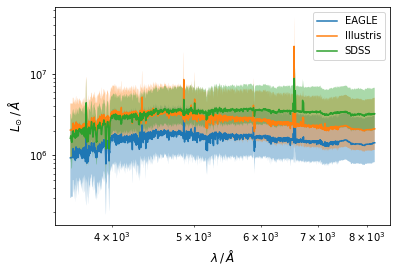

In [0]:
fig = plt.figure()

plt.loglog(wl, np.median(eagle_spec, axis=0), label='EAGLE')
plt.fill_between(wl, np.percentile(eagle_spec, q=16, axis=0), 
                 np.percentile(eagle_spec, q=84, axis=0), alpha=0.4)

plt.loglog(wl, np.median(illustris_spec, axis=0), label='Illustris')
plt.fill_between(wl, np.percentile(illustris_spec, q=16, axis=0), 
                 np.percentile(illustris_spec, q=84, axis=0), alpha=0.4)

plt.loglog(wl, np.median(vespa_spec, axis=0), label='SDSS')
plt.fill_between(wl, np.percentile(vespa_spec, q=16, axis=0), 
                 np.percentile(vespa_spec, q=84, axis=0), alpha=0.4)

plt.ylabel('$L_{\odot} \,/\, \AA$', size=12)
plt.xlabel('$\lambda \,/\, \AA$', size=12)

plt.legend()

# fig.savefig('plots/median_spectra_%s.png'%name, dpi=250, bbox_inches='tight')

### Self Organizing Maps

https://www.superdatascience.com/blogs/the-ultimate-guide-to-self-organizing-maps-soms

In [0]:
!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.2.3-cp36-none-any.whl size=7550 sha256=d131c7020390a50867fd283d047551cf87fa735533993991074cfd322cd2a22f
  Stored in directory: /root/.cache/pip/wheels/35/62/79/4d921062c847ee15a3bb3ac2ea984ed401c8b6b2944f08f697
Successfully built minisom


In [0]:
#Source: https://glowingpython.blogspot.com/2019/09/

from minisom import MiniSom 

In [0]:
dat = np.log10(np.vstack([illustris_spec, eagle_spec, vespa_spec]))

In [0]:
#Normalize

dat = np.apply_along_axis(lambda x: x/np.linalg.norm(x),1,dat)

In [0]:
som = MiniSom(10, 10, 4601, sigma=2.0, learning_rate=0.5) # initialization of 10x10 SOM

#sigma = initial width of neighborhoods for BMU match

#From doc: MiniSom uses a Gaussian as neighborhood function and its initial spread is specified with the parameter sigma. 

#learning rate = well, learning rate

In [0]:
som.train_random(dat, 2000) # trains the SOM with 2000 iterations; < 10 sec for 10x10, < 1 min for 30x30

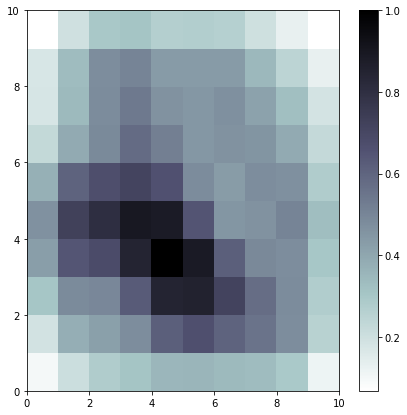

In [0]:
plt.figure(figsize=(7, 7))
plt.pcolor(som.distance_map(), cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

In [0]:
results = som.win_map(dat) #This is the map of objects associated to each BMU; 32 seconds for 10x10

In [0]:
#Build the density population map 

densitymatrix = [[len(results[(j,i)]) for i in range(10)] for j in range(10)]

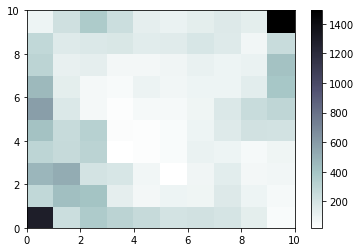

In [0]:
plt.pcolor(densitymatrix, cmap='bone_r')  # plotting the density map (number of objects matched to each BMU)
plt.colorbar()

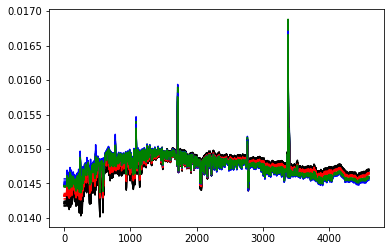

In [0]:
#This is to show that objects associated to different BMUs are more different than objects associated to different BMUs

for i in range(10):
    plt.plot(range(4601),results[(7,2)][i], color = 'k')
    plt.plot(range(4601),results[(7,3)][i], color = 'r')
    plt.plot(range(4601),results[(9,4)][i], color = 'b')
    plt.plot(range(4601),results[(8,4)][i], color = 'g')

### Convergence

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 1.2109024623162087e-08
 topographic error: 0.23953373015873017
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.2158934152881172e-08
 topographic error: 0.22767857142857142
 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 1.2008296721424313e-08
 topographic error: 0.25029761904761905
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 1.2033522836969976e-08
 topographic error: 0.2833333333333333


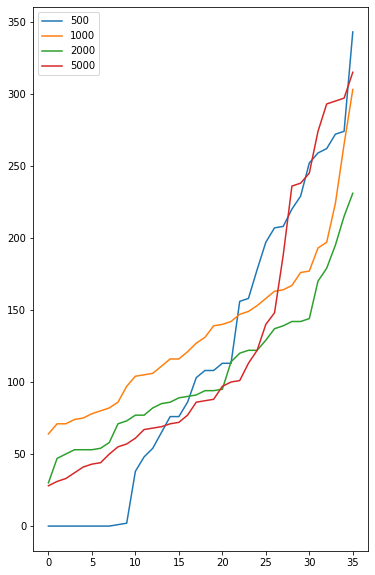

In [0]:
som2 = MiniSom(10, 10, 4601, sigma=2.0, learning_rate=0.5,  random_seed=10) # initialization of SOM, keep random seed constant

#sigma = initial width of gaussian neighborhood function for BMU match

#learning rate = well, learning rate

plt.figure(figsize=(6, 10))

for N in (500,1000,2000,5000):
    
    som2.train_random(dat, N, verbose = True) # reports quantization error, topographic error
    
    results2 = som2.win_map(dat)
    
    mat = [[len(results2[(j,i)]) for i in range(6)] for j in range(6)]
    
    plt.plot(range(36),np.sort(np.array(mat).flatten()), label = N) #plot the distribution of # of objects in nodes
        
plt.legend()

### What would happen with larger SOM?

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 1.1943930052847213e-08
 topographic error: 0.18531746031746033
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.1767946803583121e-08
 topographic error: 0.17901785714285715
 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 1.1722222610696124e-08
 topographic error: 0.17628968253968255
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 1.172325712234187e-08
 topographic error: 0.21691468253968255


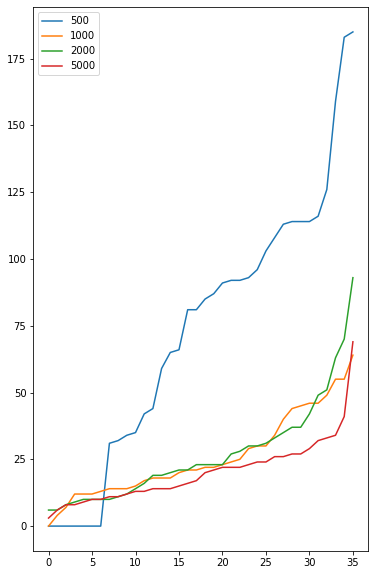

In [0]:
side = 20

som2 = MiniSom(20, 20, 4601, sigma = 2.0, learning_rate=0.5,  random_seed=10) # initialization of SOM, keep random seed constant

#sigma = initial width of gaussian neighborhood function for BMU match

#learning rate = well, learning rate

plt.figure(figsize=(6, 10))

for N in (500,1000,2000,5000):
    
    som2.train_random(dat, N, verbose = True) # reports quantization error, topographic error
    
    results2 = som2.win_map(dat)
    
    mat = [[len(results2[(j,i)]) for i in range(6)] for j in range(6)]
    
    plt.plot(range(36),np.sort(np.array(mat).flatten()), label = N) #plot the distribution of # of objects in nodes
        
plt.legend()

A larger SOM improves the topographic error; the number of iterations here seems less important. However, sigma is also supposed to enter the topographic error. Worth trying with larger sigma. 

In [0]:
side = 20

#sigma = initial width of gaussian neighborhood function for BMU match

#learning rate = well, learning rate

#plt.figure(figsize=(6, 10))

N = 2000

for sigma in (2.0, 4.0, 8.0):

  print('sigma =', sigma)

  som2 = MiniSom(20, 20, 4601, sigma = sigma, learning_rate=0.5,  random_seed=10) # initialization of SOM, keep random seed constant

  som2.train_random(dat, N, verbose = True) # reports quantization error, topographic error
    
#results2 = som2.win_map(dat)
    
#mat = [[len(results2[(j,i)]) for i in range(6)] for j in range(6)]
    
#plt.plot(range(36),np.sort(np.array(mat).flatten()), label = N) #plot the distribution of # of objects in nodes
        
#plt.legend()

sigma = 2.0
 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 1.1702697101591762e-08
 topographic error: 0.11383928571428571
sigma = 4.0
 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 1.191089075279699e-08
 topographic error: 0.18888888888888888
sigma = 8.0
 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 1.2670098265114196e-08
 topographic error: 0.20376984126984127


### Let's see with all SDSS data

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 2.008254168425674e-08
 topographic error: 0.163
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.9612863814855804e-08
 topographic error: 0.2513
 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 1.9340526783113405e-08
 topographic error: 0.1613
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 1.9299169878631224e-08
 topographic error: 0.1552


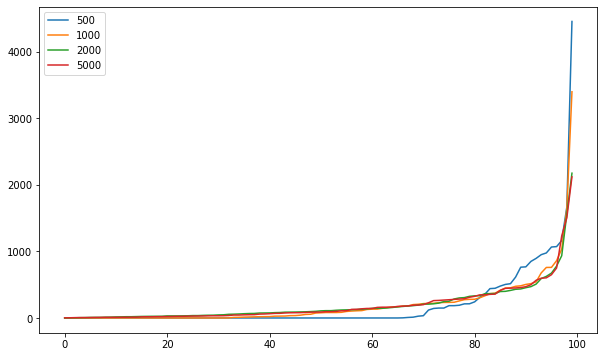

In [0]:
side = 10

som2 = MiniSom(side, side, 4601, sigma=1.0, learning_rate=0.5,  random_seed=10) # initialization of SOM, keep random seed constant

#sigma = initial width of neighboroods for BMU match

#learning rate = well, learning rate

plt.figure(figsize=(10, 6))

for N in (500,1000,2000,5000):
    
    som2.train_random(dat[-10000:], N, verbose = True) # reports quantization error, topographic error
    
    results2 = som2.win_map(dat)
    
    mat = [[len(results2[(j,i)]) for i in range(side)] for j in range(side)]
    
    plt.plot(range(side**2),np.sort(np.array(mat).flatten()), label = N) #distribution of # of objects in nodes
    
#    plt.pcolor(mat, cmap='bone_r')
#    plt.colorbar()
    
plt.legend()

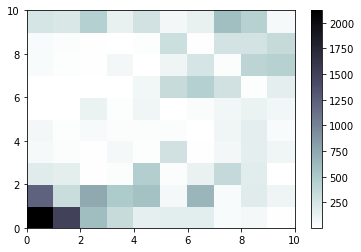

In [0]:
plt.pcolor(mat, cmap='bone_r')
plt.colorbar()

In [0]:
mat

[[2120, 1506, 603, 347, 159, 177, 181, 49, 70, 12],
 [1232, 325, 751, 500, 566, 69, 650, 50, 194, 108],
 [200, 174, 17, 34, 470, 33, 138, 358, 191, 6],
 [64, 30, 12, 75, 23, 289, 11, 79, 163, 99],
 [80, 22, 58, 32, 28, 27, 9, 95, 162, 47],
 [5, 10, 129, 25, 95, 10, 37, 87, 130, 89],
 [6, 8, 7, 10, 88, 347, 457, 284, 20, 162],
 [44, 20, 11, 78, 3, 109, 264, 29, 414, 448],
 [44, 33, 18, 2, 25, 311, 18, 274, 269, 355],
 [261, 228, 451, 143, 279, 83, 143, 597, 445, 60]]

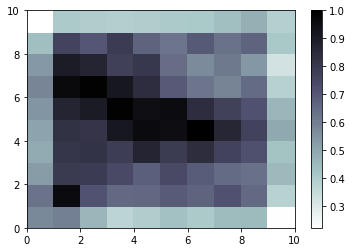

In [0]:
plt.pcolor(som2.distance_map(), cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

### We can compare quantization error within training set (SDSS) and outside

In [0]:
som2.quantization_error(dat[-10000:])

1.9299169878631224e-08

In [0]:
som2.quantization_error(dat[:-10000])

7.111566390918549e-09

Interestingly, the latter is smaller. Looks like the average distance between input and nodes is smaller. This should be a good sign.

### Let's say from above that N = 1000 works. Take a look at other params.

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.9761131213327553e-08
 topographic error: 0.1365
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.97556570633097e-08
 topographic error: 0.1168
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 2.080563385579467e-08
 topographic error: 0.0728


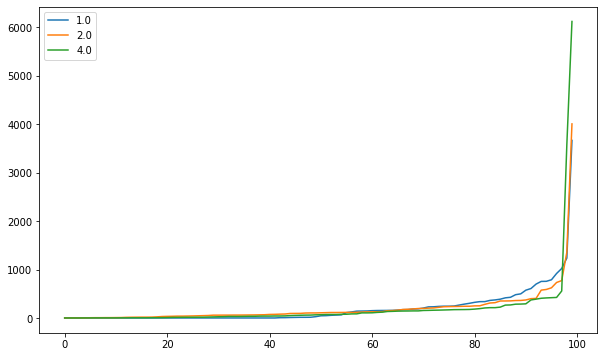

In [0]:
side = 10

#sigma = initial width of neighborhoods for BMU match

#learning rate = well, learning rate

plt.figure(figsize=(10, 6))

N = 1000

for sigma in (1.0, 2.0, 4.0):

    som2 = MiniSom(side, side, 4601, sigma=sigma, learning_rate=0.5,  random_seed=10) # initialization of SOM, keep random seed constant
    
    som2.train_random(dat[-10000:], N, verbose = True) # reports quantization error, topographic error
    
    results2 = som2.win_map(dat)
    
    mat = [[len(results2[(j,i)]) for i in range(side)] for j in range(side)]
    
    plt.plot(range(side**2),np.sort(np.array(mat).flatten()), label = sigma) #distribution of # of objects in nodes   

plt.legend()

In [0]:
w = []
for cnt,xx in enumerate(dat):
     w.append(som.winner(xx)) # getting the winner (BMU) for each object

#### Insight (to be verified): **larger sigma improves the topographic error.** It is fair to expect that sigma and learning rate should be optimized at the same time, and larger values of sigma would probably require more iterations 

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 2.1027893274494695e-08
 topographic error: 0.0402


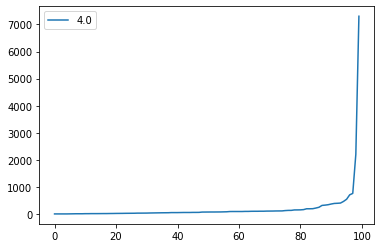

In [0]:
som2 = MiniSom(side, side, 4601, sigma=4.0, learning_rate=0.5,  random_seed=10)

som2.train_random(dat[-10000:], 5000, verbose = True) # reports quantization error, topographic error
    
results2 = som2.win_map(dat)
    
mat = [[len(results2[(j,i)]) for i in range(side)] for j in range(side)]
    
plt.plot(range(side**2),np.sort(np.array(mat).flatten()), label = sigma)

plt.legend()

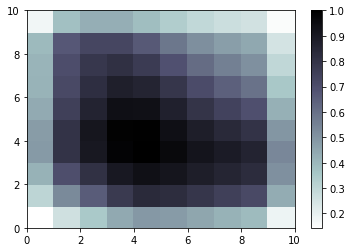

In [0]:
plt.pcolor(som2.distance_map(), cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

In [0]:
som2.distance_map()

array([[0.14343805, 0.26123496, 0.3538708 , 0.44409686, 0.49106664,
        0.4846666 , 0.45261039, 0.41961775, 0.39109213, 0.18888403],
       [0.30410731, 0.53142505, 0.6576603 , 0.7772706 , 0.83748053,
        0.82929773, 0.79201476, 0.75469793, 0.72158642, 0.43618695],
       [0.42022288, 0.70141466, 0.81035657, 0.90363686, 0.93865994,
        0.91867846, 0.88565742, 0.85899149, 0.83130342, 0.51215595],
       [0.48675294, 0.80492702, 0.90816024, 0.98544769, 1.        ,
        0.96399461, 0.9225127 , 0.89379849, 0.86474009, 0.53521393],
       [0.48109566, 0.80563556, 0.91451028, 0.99048353, 0.99469173,
        0.94236653, 0.88370057, 0.84196099, 0.80590414, 0.49595313],
       [0.43989935, 0.75326276, 0.86547456, 0.94123135, 0.93869072,
        0.87483553, 0.80088124, 0.74461025, 0.69848028, 0.42413932],
       [0.41586284, 0.71960649, 0.82156997, 0.880581  , 0.86225085,
        0.78965878, 0.70961912, 0.64679773, 0.59611103, 0.35562772],
       [0.41325574, 0.70504284, 0.7861371

**Note however that this map's population properties are very strange! **

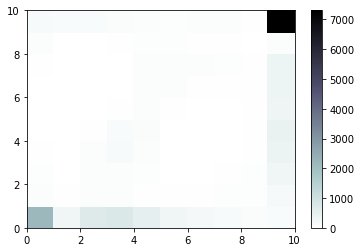

In [0]:
plt.pcolor(mat, cmap='bone_r')
plt.colorbar()

In [0]:
winners = []

for x in dat[:10]:
    winners.append(som2.winner(x))
    

#for cnt,xx in enumerate(dat):
#     w.append(som.winner(xx)) # getting the winner

In [0]:
winners

[(1, 8),
 (9, 0),
 (9, 0),
 (8, 0),
 (9, 0),
 (5, 6),
 (9, 0),
 (9, 0),
 (9, 0),
 (9, 0)]

In [0]:
som2.get_weights()[(1,8)] #coordinates of the (1,8) BMU

array([0.01348925, 0.0134017 , 0.01343821, ..., 0.01494869, 0.01495061,
       0.01496585])

### This is to find the distance of the BMU and its index

In [0]:
np.min(som2.activate(dat[0])), som2.winner(dat[0])

(0.005449122211232395, (1, 8))

We can take a look at the % difference between the first 10 objects and their BMU for Illustris data:

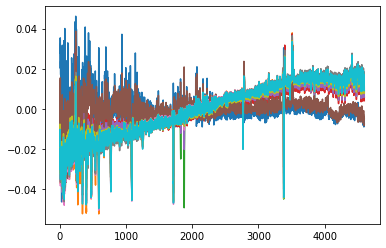

In [0]:
for i in range(10):
    plt.plot(np.arange(4601),(som2.get_weights()[som2.winner(dat[i])]-dat[i])/dat[i])
#    plt.plot(np.arange(4601),dat[i])
#plt.plot(np.arange(4601),dat[1])

And for SDSS data:

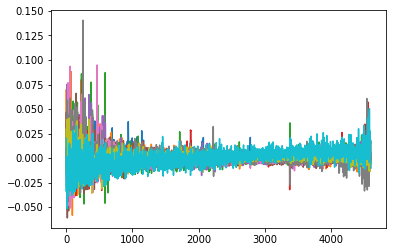

In [0]:
for i in range(10):
    plt.plot(np.arange(4601),(som2.get_weights()[som2.winner(dat[-i])]-dat[-i])/dat[-i])
#    plt.plot(dat[-i])


For evaluation of SOM quality also see:

https://homepage.cs.uri.edu/faculty/hamel/pubs/hamel-som.pdf




Note: some papers indicate  5 * sqrt(N) as plausible map size.

I'm going to repeat the above with a larger map, following the heuristic of Nodes = 5 * sqrt(N), where N = 10,000

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.891045475042749e-08
 topographic error: 0.1482


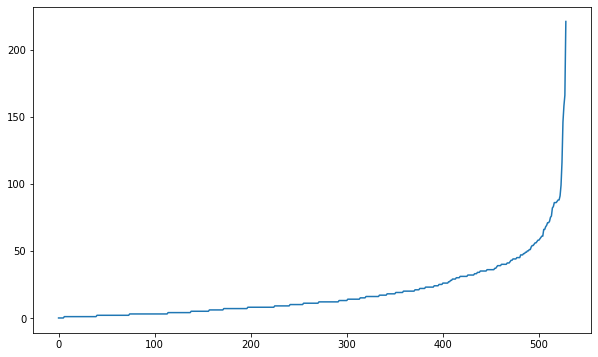

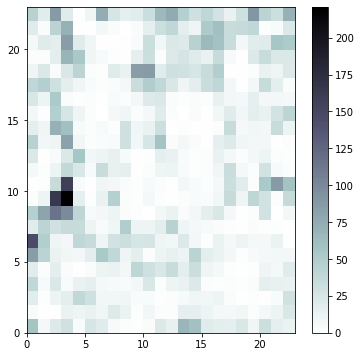

In [0]:
side = 23

#sigma = initial width of neighboroods for BMU match

#learning rate = well, learning rate

plt.figure(figsize=(10, 6))

N = 10000

sigma = 2.0

som3 = MiniSom(side, side, 4601, sigma=sigma, learning_rate=0.5,  random_seed=10) # initialization of SOM, keep random seed constant
    
som3.train_random(dat[-10000:], N, verbose = True) # reports quantization error, topographic error
    
results3 = som3.win_map(dat[-10000:])
    
mat = [[len(results3[(j,i)]) for i in range(side)] for j in range(side)]
    
plt.plot(range(side**2),np.sort(np.array(mat).flatten())) #distribution of # of objects in nodes
 
plt.figure(figsize=(6, 6))    
    
plt.pcolor(mat, cmap='bone_r')
plt.colorbar()


In the above, the distribution is more reasonable, but the topographic error is large (sigma = 2). Worth repeating with other values?

Some more thoughts on convergence of SOMs and how to find size can be found here:

https://arxiv.org/ftp/math/papers/0701/0701144.pdf

The main idea is to look at the variability of quantization error for different size using bootstrapped samples. Also, typically variability increases with number of nodes (nodes are more equivalent to each other), so this also gives an empirical criterion for map size. I'm going to keep 10x10 here.

This masters thesis explores the topic further (and uses a M = 2 N rule) but unfortunately all case uses regard very small data sets with tens/hundreds of objects.

https://homepage.cs.uri.edu/faculty/hamel/pubs/theses/ms-thesis-ben.pdf

However (great news) the paper above is from 2012, in 2018 there was another master student who studied this and made a package called POPSOM (Population-based SOMs) that assess convergence:

https://github.com/njali2001/popsom

These two papers are good resources on assessment of a map
quality and convergence:

https://homepage.cs.uri.edu/faculty/hamel/pubs/hamel-som.pdf

(2016) and

https://csce.ucmss.com/cr/books/2018/LFS/CSREA2018/ICD8051.pdf

(2018).


**Next to do: Try POPSOM**

I tried POPSOM and it cannot handle unsupervised data sets :(
